<a href="https://colab.research.google.com/github/as9786/ComputerVision/blob/main/ImageGeneration/code/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import animation, rc
import cv2

In [2]:
class PokemonDataset(Dataset):
    def __init__(self, data_dir, num='all', transforms=None):
        self.paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
        if num != 'all' and num < len(self.paths):
            self.paths = self.paths[:num]
        self.transforms = transforms
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx])
        if self.transforms is not None:
            img = self.transforms(img)
        return img

In [3]:
class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.
    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, gain=2):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [4]:
class PixelNorm(nn.Module):
    def __init__(self, eps=1e-8):
        super(PixelNorm, self).__init__()
        self.eps = eps
        
    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.eps)

In [5]:
# (Conv3*3 + LReLU + PixelNorm) * 2
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            WSConv2d(in_channels, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm(),
            WSConv2d(out_channels, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm(),
        )
    
    def forward(self, x):
        return self.block(x)

In [6]:
# ToRGB
class ToRGB(nn.Module):
    def __init__(self, in_channels):
        super(ToRGB, self).__init__()
        self.rgb = WSConv2d(in_channels, 3, 1)
        
    def forward(self, x):
        return self.rgb(x)

In [7]:
class Generator(nn.Module):
    def __init__(self, z_dim=512, in_channels=512, max_size=128):
        super(Generator, self).__init__()
        self.input = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm(),
            WSConv2d(in_channels, in_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            PixelNorm(),
        ) # out: in_channels * 4 * 4
        
        steps = int(np.log2(max_size) - 2)
        self.blocks = nn.ModuleList([])
        self.rgbs = nn.ModuleList([ToRGB(in_channels)])
        channels = in_channels
        for i in range(steps):
            if i < 3:
                self.blocks.append(ConvBlock(channels, channels))
                self.rgbs.append(ToRGB(channels))
            else:
                self.blocks.append(ConvBlock(channels, channels//2))
                self.rgbs.append(ToRGB(channels//2))
                channels = channels // 2
                
    def fade_in(self, block, up, alpha):
        return torch.tanh(alpha * block + (1 - alpha) * up)
    
    def forward(self, z, step, alpha):
        x = self.input(z)
        if step == 0:
            return self.rgbs[step](x)
        
        for i in range(step-1):
            x = F.interpolate(x, scale_factor=2, mode='nearest')
            x = self.blocks[i](x)
        
        x1 = F.interpolate(x, scale_factor=2, mode='nearest')
        block = self.rgbs[step](self.blocks[step-1](x1))
        
        up = self.rgbs[step-1](x)
        up = F.interpolate(up, scale_factor=2, mode='nearest')
        
        return self.fade_in(block, up, alpha)

In [8]:
def minibatch_standard_deviation(x):
    mean_std = torch.std(x, dim=0).mean()
    mean_std = mean_std.repeat(x.shape[0], 1, x.shape[2], x.shape[3])
    return torch.cat([x, mean_std], dim=1)

In [9]:
class FromRGB(nn.Module):
    def __init__(self, out_channels):
        super(FromRGB, self).__init__()
        self.rgb = WSConv2d(3, out_channels, 1)
        
    def forward(self, x):
        return self.rgb(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, max_size=128, out_channels=512):
        super(Discriminator, self).__init__()
        
        self.out = nn.Sequential(
            WSConv2d(out_channels+1, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            WSConv2d(out_channels, out_channels, 4)
        )
        self.linear = nn.Linear(out_channels, 1)
        
        num_blocks = int(np.log2(max_size) - 2)
        self.blocks = nn.ModuleList([])
        self.from_rgbs = nn.ModuleList([FromRGB(out_channels)])
        channels = out_channels
        for i in range(num_blocks):
            if i < 3:
                self.from_rgbs.append(FromRGB(channels))
                self.blocks.append(ConvBlock(channels, channels))
            else:
                self.from_rgbs.append(FromRGB(channels//2))
                self.blocks.append(ConvBlock(channels//2, channels))
                channels = channels // 2
        
        self.down = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def fade_in(self, block, down, alpha):
        return torch.tanh(alpha * block + (1 - alpha) * down)
    
    def forward(self, x, step, alpha):
        if step == 0:
            x = self.from_rgbs[0](x)
            x = minibatch_standard_deviation(x)
            x = self.out(x).view(x.shape[0], -1)
            return self.linear(x)
        
        block = self.down(self.blocks[step-1](self.from_rgbs[step](x)))
        down = self.from_rgbs[step-1](self.down(x))
        x = self.fade_in(block, down, alpha)
        
        for i in range(step-2, -1, -1):
            x = self.down(self.blocks[i](x))
            
        x = minibatch_standard_deviation(x)
        x = self.out(x).view(x.shape[0], -1)
        return self.linear(x)

In [11]:
def load_dict(net, model_dict, device=None):
    net_dict = net.state_dict()
    state_dict = {k:v for k,v in model_dict.items() if k in net_dict.keys()}
    net_dict.update(state_dict)
    net.load_state_dict(net_dict)
    if device is not None:
        net = net.to(device)
    return net

In [12]:
class ProWGANDLoss(nn.Module):
    def __init__(self):
        super(ProWGANDLoss, self).__init__()
    
    def gradient_penalty(self, D, real_img, fake_img, step, alpha, LAMDA=10):
        batch_size = real_img.size(0)
        device = real_img.device
        gp_alpha = torch.rand(batch_size, 1)
        gp_alpha = gp_alpha.expand(batch_size, real_img.nelement()//batch_size).reshape(real_img.shape).to(device)
        x = (gp_alpha * real_img + (1 - gp_alpha) * fake_img).requires_grad_(True).to(device)
        out = D(x, step=step, alpha=alpha)

        grad_outputs = torch.ones(out.shape).to(device)

        gradients = torch.autograd.grad(outputs=out, inputs=x, grad_outputs=grad_outputs, create_graph=True, only_inputs=True)[0]
        gradients = gradients.reshape(batch_size, -1)

        return LAMDA * ((gradients.norm(2, dim=1)-1)**2).mean()
    
    def forward(self, G, D, z, img, step, alpha):
        # D loss
        loss_real = -D(img, step=step, alpha=alpha).mean()
        fake_img = G(z, step=step, alpha=alpha)
        loss_fake = D(fake_img.detach(), step=step, alpha=alpha).mean()
        gp = self.gradient_penalty(D, img.detach(), fake_img.detach(), step=step, alpha=alpha, LAMDA=10)
        
        return loss_real + loss_fake + gp

In [13]:
class Trainer:
    def __init__(self, cfg, dataset):
        print(f'Load config')
        self.cfg = cfg
        
        print(f'Load dataset')
        self.dataset = dataset
        
        print('Init G and D models')
        self.G = Generator(z_dim=self.cfg.net.z_dim, in_channels=self.cfg.net.max_channels, max_size=self.cfg.net.max_size).to(self.cfg.train.device)
        self.D = Discriminator(max_size=self.cfg.net.max_size, out_channels=self.cfg.net.max_channels).to(self.cfg.train.device)
        
        # pretrained
        if self.cfg.net.preG_path is not None:
            print('Load pretrained G model')
            self.G = load_dict(self.G, torch.load(self.cfg.net.preG_path), device=self.cfg.train.device)
        if self.cfg.net.preD_path is not None:
            print('Load pretrained D model')
            self.D = load_dict(self.D, torch.load(self.cfg.net.preD_path), device=self.cfg.train.device)
        
        print('Set optimizers and loss function')
        self.optimizer_G = torch.optim.Adam(self.G.parameters(), lr=self.cfg.train.lr, betas=(0.0, 0.99))
        self.optimizer_D = torch.optim.Adam(self.D.parameters(), lr=self.cfg.train.lr, betas=(0.0, 0.99))
        self.lossfn_D = ProWGANDLoss().to(self.cfg.train.device)
        
        self.fixed_z = torch.normal(self.cfg.dataset.noise_mean, self.cfg.dataset.noise_std, size=(64, self.cfg.net.z_dim, 1, 1)).to(self.cfg.train.device)
        
        # output
        self.imgs = []
        print('Initial done')
        
    def get_loader(self, step):
        img_size = 2 ** (step + 2)
        transforms_ = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((img_size, img_size))
        ])
        img_dataset = self.dataset(data_dir=self.cfg.dataset.data_dir, transforms=transforms_, num=self.cfg.dataset.num_dataset)
        return len(img_dataset), DataLoader(
            img_dataset,
            batch_size=self.cfg.train.batch_size_list[step],
            shuffle=False,
            num_workers=2
        )
        
    def train(self):
        total_steps = int(np.log2(self.cfg.net.max_size) - 1)
        assert self.cfg.train.current_step < total_steps, f'current_step of config must less than {total_steps}'
        print(f'Start training at steps: {self.cfg.train.current_step+1}/{total_steps}')
        for step in range(self.cfg.train.current_step, total_steps):
            num_dataset, loader = self.get_loader(step)
            start_epoch = self.cfg.train.current_epoch if self.cfg.train.current_step == step else 0
            alpha = start_epoch * 2 / self.cfg.train.epoches if self.cfg.train.current_step == step else 1e-8
            for epoch in range(start_epoch, self.cfg.train.epoches):
                begin_time = time.time()
                for i, img in enumerate(tqdm(loader, desc=f'epoch {epoch+1}/{self.cfg.train.epoches}')):
                    z = torch.normal(self.cfg.dataset.noise_mean, self.cfg.dataset.noise_std, size=(img.size(0), self.cfg.net.z_dim, 1, 1))
                    img, z = img.to(self.cfg.train.device), z.to(self.cfg.train.device)

                    # train D
                    self.D.zero_grad()
                    loss_D = self.lossfn_D(self.G, self.D, z, img, step, alpha)
                    loss_D.backward()
                    self.optimizer_D.step()

                    # train G
                    self.G.zero_grad()
                    loss_G = -self.D(self.G(z, step=step, alpha=alpha), step=step, alpha=alpha).mean()
                    loss_G.backward()
                    self.optimizer_G.step()

                    # smooth increase alpha
                    # it reaches 1 after half of epoches
                    alpha += 2 * img.size(0) / (self.cfg.train.epoches * num_dataset)
                    alpha = min(alpha, 1)
                end_time = time.time()
                
                self.log(begin_time, end_time, step, total_steps, epoch, alpha, loss_G, loss_D)
                self.generate_img(step, alpha)
        print('Train done')
                    
    def generate_img(self, step, alpha):
        with torch.no_grad():
            out_img = make_grid(self.G(self.fixed_z, step=step, alpha=alpha), padding=2, normalize=True).cpu().permute(1,2,0).numpy()
        out_img = (out_img - np.min(out_img)) / (np.max(out_img) - np.min(out_img)).astype(np.float)
        self.imgs.append(out_img)
    
    def log(self, begin_time, end_time, step, total_steps, epoch, alpha, loss_G, loss_D):
        out_str = '[total time: {:.5f}s] '.format(end_time-begin_time) + f'[Step: {step+1}/{total_steps}] [Epoch: {epoch+1}/{self.cfg.train.epoches}] [alpha: {format(alpha, ".2e")}] [G loss: {loss_G.item()}] [D loss: {loss_D.item()}]'
        print(out_str)

In [14]:
class Config:
    def __init__(self, z_dim, max_channels, max_size, preG_path, preD_path, data_dir, num_dataset, \
                 noise_mean, noise_std, device, lr, batch_size_list, epoches, current_step, current_epoch):
        self.net = type('', (), {})()
        self.net.z_dim = z_dim
        self.net.max_channels = max_channels
        self.net.max_size = max_size
        self.net.preG_path = preG_path
        self.net.preD_path = preD_path
        
        self.dataset = type('', (), {})()
        self.dataset.data_dir = data_dir
        self.dataset.num_dataset = num_dataset
        self.dataset.noise_mean = noise_mean
        self.dataset.noise_std = noise_std
        
        self.train = type('', (), {})()
        self.train.device = device
        self.train.lr = lr
        self.train.batch_size_list = batch_size_list
        self.train.epoches = epoches
        self.train.current_step = current_step
        self.train.current_epoch = current_epoch

In [20]:
cfg = Config(
    z_dim = 512, max_channels = 512, max_size = 64, \
    preG_path = '/content/drive/MyDrive/GAN/dataset/pokemon_G_step4_dict.pth', preD_path = '/content/drive/MyDrive/GAN/dataset/pokemon_D_step4_dict.pth', \
    data_dir = '/content/drive/MyDrive/GAN/dataset/smd/smd', num_dataset = 2000, \
    noise_mean = 0, noise_std = 1, device = 'cuda', lr = 0.001, batch_size_list = 3*[1024, 256, 64, 16, 4], \
    epoches = 100, current_step = 4, current_epoch = 95
)

In [21]:
trainer = Trainer(cfg=cfg, dataset=PokemonDataset)
trainer.train()

Load config
Load dataset
Init G and D models
Load pretrained G model
Load pretrained D model
Set optimizers and loss function
Initial done
Start training at steps: 5/5


epoch 96/100:   0%|          | 0/500 [00:00<?, ?it/s]

[total time: 370.74087s] [Step: 5/5] [Epoch: 96/100] [alpha: 1.00e+00] [G loss: 2211.6142578125] [D loss: -6.771485805511475]


<ipython-input-13-f09471563e49>:85: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  out_img = (out_img - np.min(out_img)) / (np.max(out_img) - np.min(out_img)).astype(np.float)


epoch 97/100:   0%|          | 0/500 [00:00<?, ?it/s]

[total time: 324.79620s] [Step: 5/5] [Epoch: 97/100] [alpha: 1.00e+00] [G loss: 2171.607177734375] [D loss: -5.007073402404785]


epoch 98/100:   0%|          | 0/500 [00:00<?, ?it/s]

[total time: 324.96461s] [Step: 5/5] [Epoch: 98/100] [alpha: 1.00e+00] [G loss: 2231.304931640625] [D loss: -5.531282424926758]


epoch 99/100:   0%|          | 0/500 [00:00<?, ?it/s]

[total time: 325.12506s] [Step: 5/5] [Epoch: 99/100] [alpha: 1.00e+00] [G loss: 2279.0234375] [D loss: -6.931209564208984]


epoch 100/100:   0%|          | 0/500 [00:00<?, ?it/s]

[total time: 324.79097s] [Step: 5/5] [Epoch: 100/100] [alpha: 1.00e+00] [G loss: 2309.285400390625] [D loss: -4.03131628036499]
Train done


In [22]:
rc('animation', html='jshtml')
rc('animation', embed_limit=100.0)
def create_animation(ims):
    fig = plt.figure(figsize=(10, 10))
    plt.axis('off')
    im = plt.imshow(ims[0])

    def animate_func(i):
        im.set_array(ims[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 500)

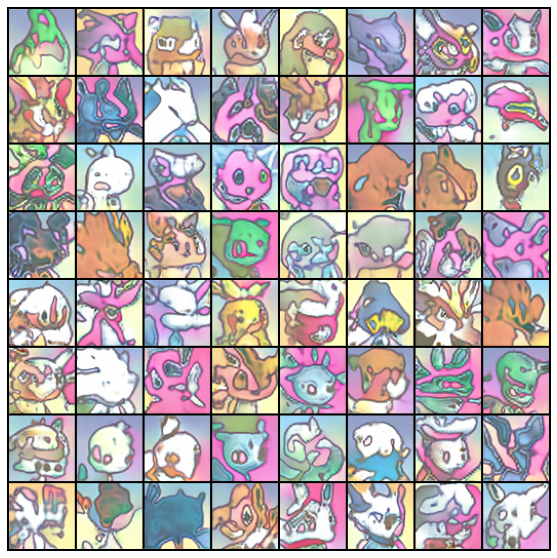

In [23]:
create_animation(np.stack(trainer.imgs))